<a href="https://colab.research.google.com/github/huanyanwei/analytics-projects/blob/main/Chi_Sq_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aim: To detect deviations in Web Server Access logs via $\chi^2$. 

Detection Fields: To test on HTTP Type, HTTP Reply Status Number & Page Surfed

## Preparation of Actual Data

In [ ]:
import pandas as pd 

df = pd.read_csv("weblog_2.csv") 
df[['Type','Page','Ignore']] = df['URL'].str.split(' ', 2, expand=True)
df[['Page','Status','Type']].head()

,Page,Status,Type
0,/login.php,200,GET
1,/process.php,302,POST
2,/home.php,200,GET
3,/js/vendor/moment.min.js,200,GET
4,/bootstrap-3.3.7/js/bootstrap.js,200,GET


Calculate % of HTTP Type and Status. 
Save the values as expected value for $\chi^2$ calculation later

In [ ]:
f_exp_status = df['Status'].value_counts(normalize=True) * 100
print(f_exp_status)

200    71.758819
302    22.154665
304     4.167458
404     1.589714
206     0.329343
Name: Status, dtype: float64


In [ ]:
f_exp_type = df['Type'].value_counts(normalize=True) * 100
print(f_exp_type)

GET     95.623535
POST     4.319463
HEAD     0.057002
Name: Type, dtype: float64


Noticed that the under `Page`, there are mant pages of the same, but string differ because of query, e.g. `/details.php?name=Magic%20Square&cod=13`. 

Hence, will remove all info from `?` onwards since the focus is on the number of times the page is surfed. 

In [ ]:
df['Page_New'] = df['Page'].str.split('?').str[0]

Noticed that under `Page`, there are pages that are only accessed less than X number of times. 

In order to perform $\chi^2$ Goodness of Fit test, need to ensure frequency of all inputs are at least of 10. (Arbitary Number, can be changed). Usually the number is 5 (?), according to YouTube. 

In [ ]:
counts = df['Page_New'].value_counts()
df = df[~df['Page_New'].isin(counts[counts < 10].index)]
df['Page_New'].value_counts().tail()

/fonts/fontawesome-webfont.woff    23
/favicon.ico                       19
/edit.php                          14
/setproblem.php                    12
/editcontestproblem.php            12
Name: Page_New, dtype: int64

From above, see that now all pages are surfed at least more than 10 times. 

In [ ]:
f_exp_page = df['Page_New'].value_counts(normalize=True) * 100
print(f_exp_page.head())

/login.php                           21.817487
/home.php                            16.894861
/js/vendor/modernizr-2.8.3.min.js     9.023753
/                                     5.489397
/contestproblem.php                   3.540725
Name: Page_New, dtype: float64


Values for `f_exp_status`, `f_exp_type` and `f_exp_page` are found and stored.

Now repeat the calculation for Modified Data. 

# Modified Data

To simulate `f_obs` 

In [ ]:
df2 = pd.read_csv("weblog_fake.csv") 
df2[['Type','Page','Ignore']] = df2['URL'].str.split(' ', 2, expand=True)

In [ ]:
f_obs_status = df2['Status'].value_counts(normalize=True) * 100
print(f_obs_status)

200    68.488978
302    28.065118
304     2.407547
404     0.822169
206     0.216188
Name: Status, dtype: float64


In [ ]:
f_obs_type = df2['Type'].value_counts(normalize=True) * 100
print(f_obs_type)

GET     92.652887
POST     7.317632
HEAD     0.029480
Name: Type, dtype: float64


In [ ]:
df2['Page_New'] = df2['Page'].str.split('?').str[0]
counts = df2['Page_New'].value_counts()
df2 = df2[~df2['Page_New'].isin(counts[counts < 10].index)]
df2['Page_New'].value_counts().tail()

/fonts/fontawesome-webfont.woff    23
/favicon.ico                       19
/index.php                         13
/editcontestproblem.php            12
/setproblem.php                    12
Name: Page_New, dtype: int64

In [ ]:
f_obs_page = df2['Page_New'].value_counts(normalize=True) * 100
print(f_obs_page.head())

/login.php                           24.605077
/home.php                            15.882295
/                                     5.274393
/process.php                          5.123321
/js/vendor/modernizr-2.8.3.min.js     4.998522
Name: Page_New, dtype: float64


Data representing expected values `f_exp` & observed values `f_obs` are ready. 

# Results: $\chi^2$ test on `f_obs` & `f_exp`

In [ ]:
from scipy.stats import chisquare
chisquare(f_obs_status, f_exp=f_exp_status)

Power_divergenceResult(statistic=2.8784683554369432, pvalue=0.5783650419060467)

In [ ]:
chisquare(f_obs_type, f_exp=f_exp_type)

Power_divergenceResult(statistic=2.18662478513726, pvalue=0.3351046551310318)

Question: do we need to define the dimension???

For page, because found out that the number of unique pages are different after the modification, took a SHORTCUT by making sure that `f_exp_page` & `f_obs_page` are of the same length. 

Assumption that the pages orders are still the same...

In [ ]:
if len(f_obs_page) > len(f_exp_page):
  diff = abs(len(f_obs_page) - len(f_exp_page))
  print("different number of unique pages...")
  print("f_obs larger...")
  print("difference by", diff)
  f_obs_page.drop(f_obs_page.tail(diff).index,inplace=True)
elif len(f_obs_page) < len(f_exp_page):
  diff = abs(len(f_obs_page) - len(f_exp_page))
  print("different number of unique pages...")
  print("f_exp larger...")
  print("difference by", diff)
  f_exp_page.drop(f_exp_page.tail(diff).index,inplace=True)
else:
  print("both lenght same...")

different number of unique pages...
f_obs larger...
difference by 1


In [ ]:
chisquare(f_obs_page, f_exp=f_exp_page)

Power_divergenceResult(statistic=7.510198308575736, pvalue=0.9999999993567241)

# Addtional: Plotting/ Visualisation

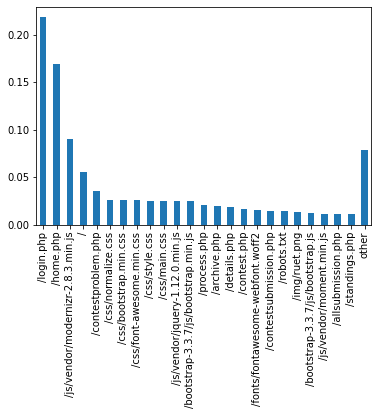

In [ ]:
prob = df['Page_New'].value_counts(normalize=True)
threshold = 0.01
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


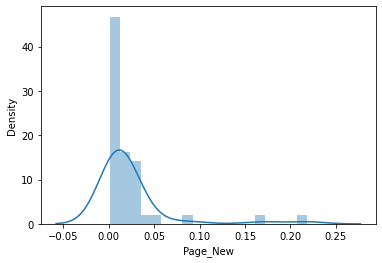

In [ ]:
import seaborn as sns
prob = df['Page_New'].value_counts(normalize=True)
sns.distplot(prob, hist=True, kde=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


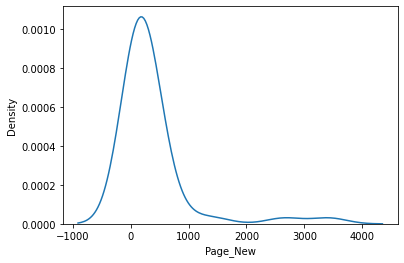

In [ ]:
import seaborn as sns
prob = df['Page_New'].value_counts(normalize=False)
sns.distplot(prob, hist=False, kde=True)